# Bonus 1: Numerical Optimization for Logistic Regression.

### Name: Wenbo Cao


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance. (1 bonus point.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Github repo.

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2019F/blob/master/homework/Bonus1/Bonus1.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file(r'D:\sit\2019Fall\Deep Learning\Bonus1\diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = int(numpy.ceil(n * 0.8))
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (615, 8)
Shape of x_test: (153, 8)
Shape of y_train: (615, 1)
Shape of y_test: (153, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.0824532  -0.04673405  0.02931964  0.02225372  0.00171416  0.04719932
  -0.08665877 -0.03625847]]
test std = 
[[0.95619468 1.02881307 0.9721778  1.06188232 1.10346945 1.16297777
  0.86169795 0.93646417]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (615, 9)
Shape of x_test: (153, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [6]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [7]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [8]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [9]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [10]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5952789510080022
Objective value at t=2 is 0.553401209649841
Objective value at t=3 is 0.5301933099338973
Objective value at t=4 is 0.5154650595028012
Objective value at t=5 is 0.5053992495462825
Objective value at t=6 is 0.4981976735529879
Objective value at t=7 is 0.4928810686937872
Objective value at t=8 is 0.48886358163051913
Objective value at t=9 is 0.48577177199573807
Objective value at t=10 is 0.48335663809815155
Objective value at t=11 is 0.48144644948089765
Objective value at t=12 is 0.479919568762531
Objective value at t=13 is 0.478687930494374
Objective value at t=14 is 0.4776865800684243
Objective value at t=15 is 0.4768668329638009
Objective value at t=16 is 0.4761916817607896
Objective value at t=17 is 0.4756326426174453
Objective value at t=18 is 0.47516754757477914
Objective value at t=19 is 0.4747789721531526
Objective value at t=20 is 0.47445309796296564
Objective value at t=21 is 0.474178878362

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [12]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [13]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [14]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5371463170410598
Objective value at epoch t=1 is 0.5271993592850056
Objective value at epoch t=2 is 0.512089691089159
Objective value at epoch t=3 is 0.5111392016581336
Objective value at epoch t=4 is 0.5048007765436299
Objective value at epoch t=5 is 0.5067008826835935
Objective value at epoch t=6 is 0.5019983290595897
Objective value at epoch t=7 is 0.4978978384827085
Objective value at epoch t=8 is 0.4948041380477319
Objective value at epoch t=9 is 0.49726742748969366
Objective value at epoch t=10 is 0.49053777942031157
Objective value at epoch t=11 is 0.49373505027205566
Objective value at epoch t=12 is 0.4876499579061398
Objective value at epoch t=13 is 0.49083423152529293
Objective value at epoch t=14 is 0.4871232715052905
Objective value at epoch t=15 is 0.4823448059329144
Objective value at epoch t=16 is 0.48437736599870845
Objective value at epoch t=17 is 0.4825501041343629
Objective value at epoch t=18 is 0.48134386746275604
Objective value a

# 4. Compare GD with SGD

Plot objective function values against epochs.

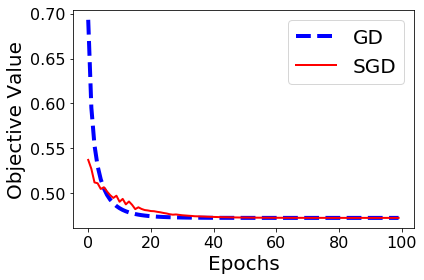

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [16]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [17]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.22113821138211381


In [18]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1895424836601307


# 6. Mini-batch SGD (fill the code)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

In [37]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications   
    
    
    # Define the 
    n,d = xi.shape
    yx = numpy.multiply(yi, xi)# n-by-d matrix
    yxw = numpy.dot(yx,w) # d-by-1 matrix
    
    
    
    obj = (1/b) * numpy.sum(numpy.log(1 + numpy.exp(-yxw))) + lam/2 * numpy.sum(w*w)
    
    g = -(1/b) * numpy.sum( numpy.divide(yx, 1+numpy.exp(yxw))) + lam*w
    
    
    
    return obj, g

## 6.2. Implement mini-batch SGD

In [38]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n,d =x.shape
    objvals = numpy.zeros(max_epoch)
    if w is None:
        w = numpy.zeros((d,1))
    
    
    # Mini-batch
    for t in range(max_epoch):
    
        num_batch = int(numpy.ceil(x.shape[0]/b))
        objval = 0
        for i in range(1,num_batch+1):
            mini_x = x[(i-1)*b:i*b, :]
            mini_y = y[(i-1)*b:i*b, :]
            obj, g = mb_stochastic_objective_gradient(w, mini_x, mini_y, lam, b)

            # Update the parameters
            objval += obj
            w -= stepsize*g # Update w accroding to g
        
        objval /= n
        objvals[t] = objval
        stepsize *= 0.9
    
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    return w, objvals

## 6.3. Run MB-SGD

In [39]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.08318946638637102
Objective value at epoch t=1 is 0.0830815096514128
Objective value at epoch t=2 is 0.08288783357913486
Objective value at epoch t=3 is 0.08272002694568609
Objective value at epoch t=4 is 0.08257382231772575
Objective value at epoch t=5 is 0.08244576870717531
Objective value at epoch t=6 is 0.0823330619467411
Objective value at epoch t=7 is 0.08223341846782269
Objective value at epoch t=8 is 0.08214497457144565
Objective value at epoch t=9 is 0.08206620251966881
Objective value at epoch t=10 is 0.08199583938724565
Objective value at epoch t=11 is 0.08193282704122921
Objective value at epoch t=12 is 0.08187626313788678
Objective value at epoch t=13 is 0.08182536377192279
Objective value at epoch t=14 is 0.08177943809945253
Objective value at epoch t=15 is 0.08173787393870284
Objective value at epoch t=16 is 0.08170013166492006
Objective value at epoch t=17 is 0.081665742551062
Objective value at epoch t=18 is 0.08163430768171527
Objecti

In [40]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.010237272742782898
Objective value at epoch t=1 is 0.010185245390724365
Objective value at epoch t=2 is 0.010184585627908554
Objective value at epoch t=3 is 0.010182611533259098
Objective value at epoch t=4 is 0.010180746977485873
Objective value at epoch t=5 is 0.010179036680258578
Objective value at epoch t=6 is 0.010177474401289084
Objective value at epoch t=7 is 0.010176051151254
Objective value at epoch t=8 is 0.01017475757851358
Objective value at epoch t=9 is 0.01017358423662802
Objective value at epoch t=10 is 0.010172521759837627
Objective value at epoch t=11 is 0.010171561024631072
Objective value at epoch t=12 is 0.010170693281268958
Objective value at epoch t=13 is 0.010169910248133301
Objective value at epoch t=14 is 0.010169204170607495
Objective value at epoch t=15 is 0.010168567850220368
Objective value at epoch t=16 is 0.010167994650825305
Objective value at epoch t=17 is 0.010167478488147273
Objective value at epoch t=18 is 0.01016701

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

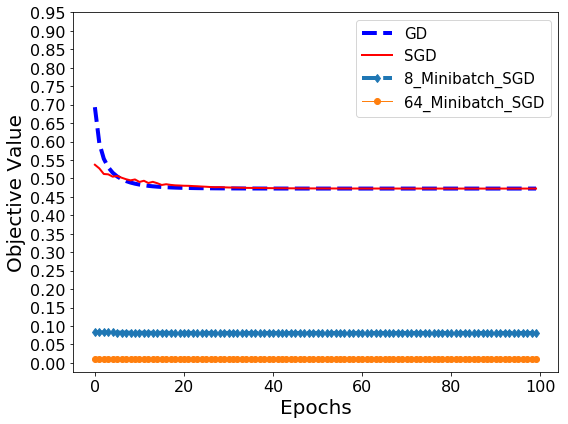

In [76]:
# plot the 4 curves:


fig = plt.figure(figsize=(8,6))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_objvals_mbsgd8 = range(len(objvals_mbsgd8))
epochs_objvals_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_objvals_mbsgd8,objvals_mbsgd8,'--d',LineWidth=4)
line3, = plt.plot(epochs_objvals_mbsgd64,objvals_mbsgd64,'-o',LineWidth=1)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(numpy.arange(0,1,0.05),FontSize=16)
plt.legend([line0, line1, line2,line3], ['GD', 'SGD','8_Minibatch_SGD','64_Minibatch_SGD'], fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)